### GENERAZIONE del dataset

Per ritrovarsi con i percorsi dei file:
1. Scaricare la repository di RoWeeder -> https://github.com/pasqualedem/RoWeeder
2. Copiare la repository nel drive
3. Montare il drive

In [2]:
import os

# crea un link simbolico
os.symlink('/content/drive/MyDrive/RoWeeder', '/content/RoweederRoot')

# Elenca i file in RoWeeder
os.listdir("/content/RoweederRoot")

In [ ]:
# Scarica lo zip

!wget http://robotics.ethz.ch/~asl-datasets/2018-weedMap-dataset-release/Orthomosaic/RedEdge.zip -d /content/RoweederRoot/dataset

In [ ]:
# Unzip del file

!unzip /content/RoweederRoot/dataset/RedEdge.zip -d /content/RoweederRoot/dataset

PREPROCESSING

In [ ]:
!pip install ruamel.yaml
!pip install streamlit

In [ ]:
# Ruota le immagini

!python3 /content/RoweederRoot/main.py rotate --root /content/RoweederRoot/dataset/RedEdge/000 --outdir /content/RoweederRoot/dataset/rotated_ortho/000 --angle -46
!python3 /content/RoweederRoot/main.py rotate --root /content/RoweederRoot/dataset/RedEdge/001 --outdir /content/RoweederRoot/dataset/rotated_ortho/001 --angle -46
!python3 /content/RoweederRoot/main.py rotate --root /content/RoweederRoot/dataset/RedEdge/002 --outdir /content/RoweederRoot/dataset/rotated_ortho/002 --angle -46
!python3 /content/RoweederRoot/main.py rotate --root /content/RoweederRoot/dataset/RedEdge/003 --outdir /content/RoweederRoot/dataset/rotated_ortho/003 --angle -46
!python3 /content/RoweederRoot/main.py rotate --root /content/RoweederRoot/dataset/RedEdge/004 --outdir /content/RoweederRoot/dataset/rotated_ortho/004 --angle -46

In [ ]:
# Crea le patch

!python3 /content/RoweederRoot/main.py patchify --root /content/RoweederRoot/dataset/rotated_ortho/000 --outdir /content/RoweederRoot/dataset/patches/512/000 --patch_size 512 &
!python3 /content/RoweederRoot/main.py patchify --root /content/RoweederRoot/dataset/rotated_ortho/001 --outdir /content/RoweederRoot/dataset/patches/512/001 --patch_size 512 &
!python3 /content/RoweederRoot/main.py patchify --root /content/RoweederRoot/dataset/rotated_ortho/002 --outdir /content/RoweederRoot/dataset/patches/512/002 --patch_size 512 &
!python3 /content/RoweederRoot/main.py patchify --root /content/RoweederRoot/dataset/rotated_ortho/003 --outdir /content/RoweederRoot/dataset/patches/512/003 --patch_size 512 &
!python3 /content/RoweederRoot/main.py patchify --root /content/RoweederRoot/dataset/rotated_ortho/004 --outdir /content/RoweederRoot/dataset/patches/512/004 --patch_size 512

Terminato il preprocessing:
4. Trasferire l'intera cartella dataset (contenuta nella repo di RoWeeder) nella root del Drive.
5. Se desiderato è ora possibile rimuovere la repository Roweeder per recuperare spazio sul Drive.
6. Nel seguente codice del notebook controllare che i percorsi inseriti corrispondano. Se così non fosse allora è importante aggiornarli.



---



---



---



---


In [5]:
# !pip install transformers datasets evaluate
# !pip list

In [4]:
import transformers
import datasets
import evaluate

# print(transformers.__version__)
# print(datasets.__version__)
# print(evaluate.__version__)

In [124]:
# GLOBAL VARIABLES
FOLDER_PATH_w = "/kaggle/working"
FOLDER_PATH_r = "/kaggle/input/trainedmodels13/FINAL_Trained_models_weights"

## Definizione PyTorch DATASETs
Tale classe verrà usata per gestire la repository di immagini figurandola come se fosse un Dataset.

In [7]:
import itertools
import os
import torch
import torchvision

from torch.utils.data import Dataset


class WeedMapDataset(Dataset):
    id2class = {
        0: "background",
        1: "crop",
        2: "weed",
    }

    # Inizialize the object
    def __init__(
        self,
        root,
        channels,
        fields,
        gt_folder=None,
        transform=None,
        target_transform=None,
        return_path=False,
        return_ndvi=False, # Return NDVI as extra channel
    ):
        super().__init__()
        self.root = root
        self.channels = channels
        self.transform = transform
        self.target_transform = target_transform
        self.return_path = return_path
        self.fields = fields
        self.return_ndvi = return_ndvi
        self.channels = channels

        # Create a Dict (index) where there is the image name for each image (a patch of the orthomosaic maps)
        # Es: index[0] = {'000': '0.png'}
        if gt_folder is None:
            self.gt_folders = {
                field: os.path.join(self.root, field, "groundtruth")
                for field in self.fields
            }
        else:
            self.gt_folders = {
                field: os.path.join(gt_folder, field) for field in self.fields
            }
            for k, v in self.gt_folders.items():
                if os.path.isdir(os.path.join(v, os.listdir(v)[0])):
                    self.gt_folders[k] = os.path.join(v, "groundtruth")

        self.index = [
            (field, filename) for field in self.fields for filename in os.listdir(self.gt_folders[field])
        ]

    # Return the number of images
    def __len__(self):
        return len(self.index)

    # Return the specific ground-truth image
    def _get_gt(self, gt_path):
        gt = torchvision.io.read_image(gt_path)
        gt = gt[[2, 1, 0], ::]
        gt = gt.argmax(dim=0)
        gt = self.target_transform(gt)
        return gt

    # Returns a specific image (as a Tensor) by concatenating all the image channels
    def _get_image(self, field, filename):
        channels = []
        for channel_folder in self.channels:
            channel_path = os.path.join(
                self.root,
                field,
                channel_folder,
                filename
            )
            channel = torchvision.io.read_image(channel_path)
            channels.append(channel)
        channels = torch.cat(channels).float()
        return self.transform(channels)

    def _get_ndvi(self, field, filename):
        nir_red_path = [
            os.path.join(
                self.root,
                field,
                ch,
                filename
            ) for ch in ["NIR", "R"]
        ]
        nir_red = [torchvision.io.read_image(channel_path).float() for channel_path in nir_red_path]
        ndvi = (nir_red[0] - nir_red[1]) / (nir_red[0] + nir_red[1])
        # Replaces NaN values with 0
        ndvi[torch.isnan(ndvi)] = 0
        return ndvi

    # Return a dict that contains the ith image of the dataset and its ground-truth
    def __getitem__(self, i):
        field, filename = self.index[i]
        gt_path = os.path.join(
            self.gt_folders[field], filename
        )
        gt = self._get_gt(gt_path)
        channels = self._get_image(field, filename)

        data_dict = {
            "image": channels,
            "target": gt,
        }
        if self.return_path:
            data_dict["name"] = gt_path

        if self.return_ndvi:
            ndvi = self._get_ndvi(field, filename)
            data_dict.ndvi = ndvi

        return data_dict

In [8]:
# Parameters sets for TRAINING
root = "/kaggle/input/weedmapdataset/patches/512"
channels = ["RGB"]
fields_TRAIN = ["000", "002", "004"]
gt_folder = "/kaggle/input/weedmapdataset/patches/512"
input_transform = lambda x: x / 255.0
target_transform=lambda x: x

# WeedMapDataset istancing
train_dataset = WeedMapDataset(
    root=root,
    channels=channels,
    fields=fields_TRAIN,
    gt_folder=gt_folder,
    transform=input_transform,
    target_transform=target_transform,
    return_path=True
    )


# Parameters sets for VALIDATION
fields_EVAL = ["001"]
# Almost the same...

# WeedMapDataset istancing
eval_dataset = WeedMapDataset(
    root=root,
    channels=channels,
    fields=fields_EVAL,
    gt_folder=gt_folder,
    transform=input_transform,
    target_transform=target_transform,
    return_path=True
    )

# Parameters sets for TEST
fields_TEST = ["003"]
# Almost the same...

# WeedMapDataset istancing
test_dataset = WeedMapDataset(
    root=root,
    channels=channels,
    fields=fields_TEST,
    gt_folder=gt_folder,
    transform=input_transform,
    target_transform=target_transform,
    return_path=True
    )


Una volta istanziato l'oggetto database è possibile gestire le varie immagini.

Es: nel box seguente viene mostarto come appare l'item 0 il quale è un dizionario con 3 chiavi:
1. image -> Il tensore rappresentante i 3 canali dell'immagine 000/0.npg
2. target -> L'immagine ground truth corrispondente
3. name -> Il percorso dell'immagine target

In [ ]:
# train_dataset[0].keys()

dict_keys(['image', 'target', 'name'])

## Definizione PyTorch DATALOADERs
Per il dataset di Training e di Test

In [9]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

eval_dataloader = DataLoader(eval_dataset, batch_size=16, shuffle=True)

test_dataloader = DataLoader(test_dataset, batch_size=65, shuffle=False)

Es: Ecco cosa contiene un Batch

In [24]:
# batch = next(iter(test_dataloader))


# This code shows the item number in a batch
# for k,v in batch.items():
#   if k != "name":
#     print(k, v.shape)

## MODELLO 1

### Definizione del MODELO
Tale modello è lo stesso per tutte le esecuzioni

In [8]:
from transformers import SegformerForSemanticSegmentation


id2label = train_dataset.id2class # -> {0:"background", 1:"crop", 2:"weed"}
label2id = {v:k for k,v in id2label.items()} # -> {'background':0, 'crop':1, 'weed':2}

# define model
segformer_model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels= len(id2label), # 3
                                                         id2label= id2label,
                                                         label2id= label2id,
)

config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/14.4M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### TRAINING del modello

In [27]:
import torch
import evaluate
from tqdm.notebook import tqdm
from torch import nn
import torch.nn.functional as F

# Define a Custom Loss Function with calibration technique (if the tecnique is None
# then it'll perform a normal cross-entropy loss)
class CustomLoss(nn.Module):
    def __init__(self, calibrationTecnique= None):
        super().__init__()
        self.calibrationTecnique = calibrationTecnique
        self.loss_fn = nn.CrossEntropyLoss(ignore_index=255)  # Ignore padding label if used

    def forward(self, logits, labels):

        # Scale width-height of prediction tensor to the shape of ground truth tensor
        upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)

        if self.calibrationTecnique is not None:
            calibrated_logits = self.calibrationTecnique(upsampled_logits)  # Apply calibration
        else:
            calibrated_logits = upsampled_logits

        return self.loss_fn(calibrated_logits, labels), calibrated_logits



def train_model(model = None, calibrationTecnique = None):

  # Define evaluation metrics
  iou_metric = evaluate.load("mean_iou")
  f1_metric = evaluate.load("f1")

  # Define the custom loss function
  custom_loss_fn = CustomLoss(calibrationTecnique)

  # Define optimizer
  optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)

  # move model to GPU
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)

  # Set to training mode
  model.train()

  for epoch in range(30):  # loop over the dataset multiple times
    print("Epoch:", epoch)
    for idx, batch in enumerate(tqdm(train_dataloader)):
          # get the inputs;
          pixel_values = batch["image"].to(device)
          labels = batch["target"].to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(pixel_values=pixel_values, labels=labels)
          logits = outputs.logits

          # Compute custom loss
          loss, _ = custom_loss_fn(logits, labels)

          loss.backward()
          optimizer.step()

          # evaluation for training
          with torch.no_grad():
            # Scale width-height of prediction tensor to the shape of ground truth tensor
            upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)

            softmaxes = F.softmax(upsampled_logits, dim=1)
              
            # Choose the most probable class for each pixel
            predicted = softmaxes.argmax(dim=1)

            # note that the metric expects predictions + labels as numpy arrays
            iou_metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())


          # let's print loss and metrics every 100 batches (we have only 18 batch for epoch, so... print them only one)
          if idx % 100 == 0:

            # IoU metric
            iou_metrics = iou_metric._compute(
                    predictions=predicted.cpu(),
                    references=labels.cpu(),
                    num_labels=len(id2label),
                    ignore_index=255,
                    reduce_labels=False, # we've already reduced the labels ourselves
                )

            # F1 metric
            f1_metrics = f1_metric._compute(
                    predictions=predicted.cpu().flatten(),  # Flatten tensors for classification metrics
                    references=labels.cpu().flatten(),
                    average="macro"
                )

            print("Loss:", loss.item())
            print("Mean_iou:", iou_metrics["mean_iou"])
            print("Mean accuracy:", iou_metrics["mean_accuracy"])
            print("Mean f1:", f1_metrics["f1"])

In [14]:
train_model(segformer_model)

### SALVATAGGIO dei PESI del modello
A differenza di tutto il modello, salvare solo i pesi permette di non occupare troppo spazio.

In [ ]:
# FOLDER_PATH_w = "/kaggle/working/Trained_models_weights"
# FOLDER_PATH_r = "/kaggle/input/trainedmodels.../Trained_models_weights"

In [125]:
import os
import torch

# This function saves the model weights in a local folder
def save_model_weights(model, folder_path=FOLDER_PATH_w, model_name="model_x.pth"):

    model_path = os.path.join(folder_path, model_name)

    # Create the folder if doesn't exists
    os.makedirs(folder_path, exist_ok=True)

    # Save model weights
    torch.save(model.state_dict(), model_path, _use_new_zipfile_serialization=False)

    print(f"✅ Model weights saved to {model_path}")

In [13]:
model_name = "segformer_model1_30ep.pth"

save_model_weights(model=segformer_model, model_name=model_name)

✅ Model weights saved to /kaggle/working/Trained_models_weights/segformer_model1_30ep.pth


### INFERENZA

In [126]:
# Returns the initialized model with the correct weights
def load_model_segformer(folder_path=FOLDER_PATH_r, model_name = None):

  # Define model
  segformer_model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                          num_labels=len(id2label),
                                                          id2label=id2label,
                                                          label2id=label2id,
  )

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
  model_path = os.path.join(folder_path, model_name)

  # Load weights
  segformer_model.load_state_dict(torch.load(model_path, map_location=device))
    
  print(f"✅ Model weights loaded from {model_path}")

  return segformer_model

In [153]:
model_name = "segformer_model1_30ep.pth"

# Load model architecture from local folder
segformer_model = load_model_segformer(model_name=model_name)

In [12]:
from torch import nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
from transformers import AutoImageProcessor

def make_predictions(model, calibrate_fn=None, parameters=None):

  # move model to GP
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)

  # Set to evaluation mode
  model.eval()

  # Dataloader returns a single batch of all test images
  for idx, batch in enumerate(tqdm(test_dataloader)):
    # print("Batch:", idx)

    # get the inputs
    pixel_values = batch["image"].to(device)

    # get target
    labels = batch["target"].to(device)

    # forward pass
    with torch.no_grad():
      outputs = model(pixel_values=pixel_values)
        


  # PROBLEM: logits are of shape (batch_size, num_labels, height/4, width/4)
  logits = outputs.logits.cpu()
  # print(f"Logits shape -> {logits.shape}")

  '''
  This dimensions is a PROBLEM, so:
  1. Reshape the logits tensor shape to be the same as the input one.
  2. Calibrate the logits (if there is a tecnique)
  3. Apply a softmax to the logits.
  4. Compact channels by classifying each pixel
  '''

  # Scale width-height of prediction tensor to the shape of ground truth tensor
  upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
  # print(F.softmax(upsampled_logits, dim=1)[0,:, 347,347]) #-------------------------------- DEBUG

  if calibrate_fn is not None:
      # Apply the scaling
      upsampled_logits = calibrate_fn(upsampled_logits, parameters)

  # Get the class probability for each pixel
  probs = F.softmax(upsampled_logits, dim=1)
  # print(probs[0,:, 347,347]) #-------------------------------- DEBUG
    
  # Choose the most probable class for each pixel  
  predicted_segmentation_map = probs.argmax(dim=1)
  print(f"Shape of predicted_segmentation_map -> {predicted_segmentation_map.shape}")

  return upsampled_logits, predicted_segmentation_map, labels

In [154]:
logits, predicted_segmentation_map, labels = make_predictions(segformer_model)

  0%|          | 0/1 [00:00<?, ?it/s]

Shape of predicted_segmentation_map -> torch.Size([65, 512, 512])


### F1 score

In [13]:
import evaluate


# print the F1 scores
def print_F1_score(predictions, labels):

  # Define the evaluation metrics
  f1_metric = evaluate.load("f1")

  # metric expects a list of numpy arrays for both predictions and references
  f1_metrics = f1_metric._compute(
                    predictions=predictions.detach().cpu().flatten(),
                    references=labels.detach().cpu().flatten(),
                    average=None # This ensures per-class F1 scores are returned
                )

  # Print overall mean F1 score
  print("Mean F1:", f1_metrics["f1"].mean())

  # Print F1 score per class
  for class_id, class_name in id2label.items():
      print(f"F1 score for {class_name} (class {class_id}): {f1_metrics['f1'][class_id]}")

In [28]:
print_F1_score(predicted_segmentation_map, labels)

### ECE score

In [15]:
import torch.nn.functional as F
import numpy as np

def expected_calibration_error(logits, predicted_labels, true_labels, M=5):

    accuracy_in_bin_list = []
    avg_confidence_in_bin_list = []

    # uniform binning approach with M number of bins
    bin_boundaries = np.linspace(0, 1, M + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    # Get the max probability for each pixel
    probs = F.softmax(logits, dim=1)
    confidences = torch.max(probs, dim=1)[0].flatten()

    # Predictions
    predicted_labels = predicted_labels.flatten()

    # Ground-truth
    true_labels = true_labels.flatten()

    # get a boolean Tensor of correct/false predictions
    accuracies = predicted_labels.to(logits.device) == true_labels.to(logits.device)

    ece = 0.0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # determine if sample is in bin m (between bin lower & upper)
        in_bin = np.logical_and(confidences > bin_lower.item(), confidences <= bin_upper.item()).bool()
        # can calculate the empirical probability of a sample falling into bin m: (|Bm|/n)
        prob_in_bin = in_bin.float().mean()

        if prob_in_bin.item() > 0:
            # get the accuracy of bin m: acc(Bm)
            accuracy_in_bin = accuracies[in_bin].float().mean().item()
            # get the average confidence of bin m: conf(Bm)
            avg_confidence_in_bin = confidences[in_bin].float().mean().item()
            # calculate |acc(Bm) - conf(Bm)| * (|Bm|/n) for bin m and add to the total ECE
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prob_in_bin

            accuracy_in_bin_list.append(accuracy_in_bin)
            avg_confidence_in_bin_list.append(avg_confidence_in_bin)

    return ece.item(), accuracy_in_bin_list, avg_confidence_in_bin_list

In [163]:
N_BINS = 10

ece, accuracy_in_bin_list, avg_confidence_in_bin_list = expected_calibration_error(
                                                                                    logits,
                                                                                    predicted_segmentation_map,
                                                                                    labels,
                                                                                    N_BINS
                                                                                  )

In [164]:
print(f"ECE -> {ece}")
print(f"Accuracy for each bin -> {accuracy_in_bin_list}")
print(f"Confidence for each bin -> {avg_confidence_in_bin_list}")

ECE -> 0.0484527163207531
Accuracy for each bin -> [0.39665064215660095, 0.5081251263618469, 0.6084268093109131, 0.7383509278297424, 0.8630011081695557, 0.9653077125549316, 0.999017059803009]
Confidence for each bin -> [0.3783438503742218, 0.4688854217529297, 0.5504251718521118, 0.6515079140663147, 0.7536333799362183, 0.8592009544372559, 0.9592062830924988]


### Reliability Diagram

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def show_reliability_diagram(accuracy_bins, ece=None):

  # Create a figure and axis
  fig, ax = plt.subplots(figsize=(6,4))

  # ---------------------------------------------------------------LINE---------
  # Draw the bisector of the first and third quadrants
  x = np.linspace(0, 1, 100)
  ax.plot(x, x, color='black', linestyle='--', alpha=0.5)



  # Create 10 bins between 0 and 1. There are 11 edges for 10 bins.
  confidence_bins = np.arange(0, 11)/10

  # Calculate bin centers for plotting the bars
  bin_centers = (confidence_bins[:-1] + confidence_bins[1:]) / 2



  # -------------------------------------------------------------BAR CHART 1----
  # Reshape accuracy_bins to the correct length
  achieved_accuracy = np.zeros(10)
  achieved_accuracy[-len(accuracy_bins):] = accuracy_bins

  # Draw bars representing the accuracy achieved by the bins
  bar1 = ax.bar(bin_centers, achieved_accuracy, width=0.1, edgecolor='blue',
                alpha=0.5, align='center')



  # -------------------------------------------------------------BAR CHART 2----
  # the right accuracy for each bin
  balanced_accuracy = np.arange(1,11)/10
  balanced_accuracy[: (10 - len(accuracy_bins)) ] = 0
  balanced_accuracy -= achieved_accuracy


  bar2 = ax.bar(bin_centers, balanced_accuracy, bottom=achieved_accuracy, width=0.1,
                facecolor='none', edgecolor='red', align='center')


  ax.set_ylabel('Accuracy')
  ax.set_title('Reliability Diagram')
  ax.set_xticks(confidence_bins)
  ax.legend([bar1, bar2], ['Outputs', 'Gap/Surplus',])

  ax.text(0.35, 0.9, f"ECE= {ece:.3f}", transform=ax.transAxes, fontsize=14, fontweight='bold')


  plt.show()

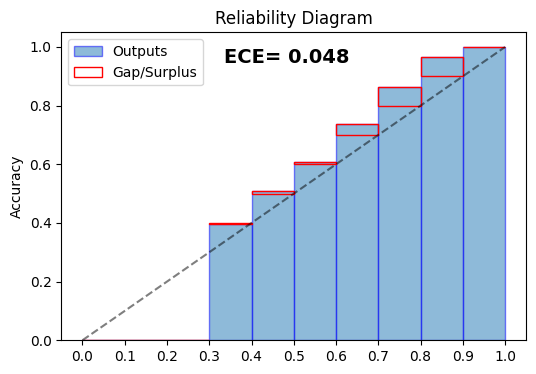

In [166]:
show_reliability_diagram(accuracy_in_bin_list, ece)

#### AREA SPERIMENTALE

In [17]:
import torch
import torch.nn.functional as F

def static_calibration_error(logits, labels, num_classes=3, n_bins=10):
    """
    Computes Static Calibration Error (SCE) for a batch of segmentation outputs.

    Args:
        logits: Tensor of shape [B, C, H, W]
        labels: Tensor of shape [B, H, W]
        num_classes: number of classes
        n_bins: number of bins to compute calibration in

    Returns:
        sce: scalar tensor, the static calibration error
    """

    label2id = {'background':0, 'crop':1, 'weed':2}
    
    sce = 0.0 
    sce_for_class = {'background': 0, 'crop': 0, 'weed': 0}
    
    B, C, H, W = logits.shape

    probs = F.softmax(logits.to(logits.device), dim=1)           # [B, C, H, W]
    confs, preds = torch.max(probs, dim=1)     # [B, H, W]
    
    for key, cls in label2id.items():
        # Create mask for where ground truth == current class
        cls_mask = (labels == cls).to(logits.device)             # [B, H, W]
        
        # Probabilities for class 'cls' at each pixel
        cls_probs = probs[:, cls, :, :]        # [B, H, W]
        
        # Correct predictions for that class
        cls_correct = (preds == cls) & cls_mask   # [B, H, W]
        
        # Mask out irrelevant values
        cls_probs = cls_probs[cls_mask]        # [N] for class cls
        cls_correct = cls_correct[cls_mask].float()  # [N] correctness
        
        if cls_probs.numel() == 0:
            continue  # no pixels of this class in batch

        # Binning
        bin_boundaries = torch.linspace(0, 1, steps=n_bins + 1, device=logits.device)
        for i in range(n_bins):
            low, high = bin_boundaries[i], bin_boundaries[i + 1]
            in_bin = (cls_probs >= low) & (cls_probs < high)

            if in_bin.sum() > 0:
                avg_conf = cls_probs[in_bin].mean()
                acc = cls_correct[in_bin].mean()
                
                sce += torch.abs(avg_conf - acc) * in_bin.float().mean()
                sce_for_class[key] += torch.abs(avg_conf - acc) * in_bin.float().mean()

    return sce / num_classes, sce_for_class


In [159]:
N_BINS = 10

sce, sce_for_class_list = static_calibration_error(
                                                    logits,
                                                    labels,
                                                    n_bins= N_BINS
                                                  )

print(f"Static calibration Error -> {sce}")

Static calibration Error -> 0.1587281972169876


In [160]:
sce_for_class_list

{'background': tensor(0.0604), 'crop': tensor(0.2118), 'weed': tensor(0.2039)}

## MODELLO 2

### Definizione del MODELLO

In [18]:
model2_name = "segformer_model1_30ep.pth"

# Load the base model
segformer_model2 = load_model_segformer(model_name=model2_name)

### Platt Scaling

#### Esempio dimostrativo

In [17]:
import torch
import numpy as np

W = torch.ones(size=(2,2)) # weights
b = torch.ones(size=(2, 1)) #Intercepts

temp = torch.Tensor([
    # batch 1
    [[[1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]]
    ,
    [[10, 20, 30],
    [40, 50, 60],
    [70, 80, 90]]]
    ,# batch 2
    [[[1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]]
    ,
    [[10, 20, 30],
    [40, 50, 60],
    [70, 80, 90]]]
])

temp[1,:,:,:] *= 11

temp

tensor([[[[  1.,   2.,   3.],
          [  4.,   5.,   6.],
          [  7.,   8.,   9.]],

         [[ 10.,  20.,  30.],
          [ 40.,  50.,  60.],
          [ 70.,  80.,  90.]]],


        [[[ 11.,  22.,  33.],
          [ 44.,  55.,  66.],
          [ 77.,  88.,  99.]],

         [[110., 220., 330.],
          [440., 550., 660.],
          [770., 880., 990.]]]])

In [ ]:
reshape1 = temp.reshape(temp.shape[0], temp.shape[1], -1)
reshape1

tensor([[[  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.],
         [ 10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90.]],

        [[ 11.,  22.,  33.,  44.,  55.,  66.,  77.,  88.,  99.],
         [110., 220., 330., 440., 550., 660., 770., 880., 990.]]])

In [ ]:
# Permute dimensions to (C, B, W)
reshape1_permutated = reshape1.permute(1, 0, 2)  # shape becomes (2, 2, 9)
reshape1_permutated

tensor([[[  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.],
         [ 11.,  22.,  33.,  44.,  55.,  66.,  77.,  88.,  99.]],

        [[ 10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90.],
         [110., 220., 330., 440., 550., 660., 770., 880., 990.]]])

In [ ]:
Z = reshape1_permutated.reshape(2, -1)
# Z = W@Z+b

tensor([[  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  11.,  22.,  33.,
          44.,  55.,  66.,  77.,  88.,  99.],
        [ 10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 110., 220., 330.,
         440., 550., 660., 770., 880., 990.]])

In [ ]:
# RETURN to back
reshape1_permutated_BACK = Z.reshape((2, 2, 9))
reshape1_permutated_BACK

tensor([[[  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.],
         [ 11.,  22.,  33.,  44.,  55.,  66.,  77.,  88.,  99.]],

        [[ 10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90.],
         [110., 220., 330., 440., 550., 660., 770., 880., 990.]]])

In [ ]:
reshape1_BACK = reshape1_permutated_BACK.permute(1, 0, 2)
reshape1_BACK


tensor([[[  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.],
         [ 10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90.]],

        [[ 11.,  22.,  33.,  44.,  55.,  66.,  77.,  88.,  99.],
         [110., 220., 330., 440., 550., 660., 770., 880., 990.]]])

In [ ]:
temp_back = reshape1_BACK.reshape(2, 2, 3, 3)
temp_back

tensor([[[[  1.,   2.,   3.],
          [  4.,   5.,   6.],
          [  7.,   8.,   9.]],

         [[ 10.,  20.,  30.],
          [ 40.,  50.,  60.],
          [ 70.,  80.,  90.]]],


        [[[ 11.,  22.,  33.],
          [ 44.,  55.,  66.],
          [ 77.,  88.,  99.]],

         [[110., 220., 330.],
          [440., 550., 660.],
          [770., 880., 990.]]]])

In [ ]:
# Dimensions check
temp - temp_back

tensor([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],


        [[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]]])

#### --- Fine esempio

In [63]:
from torch import nn


# Define Matrix scaling Calibration
class MatrixScaling(nn.Module):
    def __init__(self, n_batches = None, n_channels = 0, height = 0, width = 0):
        super().__init__()
        if n_batches is not None:
          self.B = n_batches
        self.C = n_channels
        self.H = height
        self.W = width

        self.P = nn.Parameter(torch.ones( (self.C, self.C) ))  # Learnable P parameters
        self.b = nn.Parameter(torch.ones( (self.C, 1) ))  # Learnable b parameter


    def forward(self, logits):

        # FLATTING

        # Flatten the matrices of each channel and of each batch
        reshape1 = logits.reshape(logits.shape[0], self.C, -1) # shape = (16, 3, 262'144)

        # Permute dimensions to (C, B, W)
        reshape1_permutated = reshape1.permute(1, 0, 2) # shape = (3, 16, 262'144)

        # Concatenate all different batch vectors for each channel
        Z = reshape1_permutated.reshape(self.C, -1) # shape (3, 4'194'304)


        calibrated_logits = self.P.to(logits.device)@Z + self.b.to(logits.device) # Scale the logits


        # THICKENING

        # For each channel, the rows of the matrix belong to different batch
        reshape1_permutated_BACK = calibrated_logits.reshape(self.C, logits.shape[0], -1) # shape = (3, 16, 262'144)

        # Permute dimensions to (B, C, W)
        reshape1_BACK = reshape1_permutated_BACK.permute(1, 0, 2) # shape = (16, 3, 262'144)

        return reshape1_BACK.reshape(logits.shape[0], self.C, self.H, self.W)

### FINE-TUNE del modello

In [100]:
import torch
import evaluate
from tqdm.notebook import tqdm
import torch.nn.functional as F


def FineTune_model(model = None, calibrationTecnique = None):

  # Define evaluation metrics
  iou_metric = evaluate.load("mean_iou")
  f1_metric = evaluate.load("f1")

  # Define the custom loss function
  custom_loss_fn = CustomLoss(calibrationTecnique)

  # Print parameters -----------------------------------------DEBUG

  for name, param in custom_loss_fn.named_parameters():
    print(name, param.shape, param.requires_grad)

  # Define optimizer
  optimizer = torch.optim.AdamW(custom_loss_fn.parameters(), lr=0.006)

  # move model to GPU
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)

  # Set to training mode
  model.train()

  for epoch in range(15):  # loop over the dataset multiple times
    print("Epoch:", epoch)
    for idx, batch in enumerate(tqdm(eval_dataloader)):
          # get the inputs;
          pixel_values = batch["image"].to(device)
          labels = batch["target"].to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(pixel_values=pixel_values, labels=labels)
          logits = outputs.logits

          loss, calibrated_logits = custom_loss_fn(logits, labels)

          loss.backward()

          optimizer.step()

          # evaluation for training
          with torch.no_grad():

            softmaxes = F.softmax(calibrated_logits, dim=1)
              
            # Choose the most probable class for each pixel
            predicted = softmaxes.argmax(dim=1)

            # note that the metric expects predictions + labels as numpy arrays
            iou_metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())


            # let's print loss and metrics every 100 batches (we have only 18 batch for epoch, so... print them only one)
            if idx % 100 == 0:

              # IoU metric
              iou_metrics = iou_metric._compute(
                      predictions=predicted.cpu(),
                      references=labels.cpu(),
                      num_labels=len(id2label),
                      ignore_index=255,
                      reduce_labels=False, # we've already reduced the labels ourselves
                  )

              # F1 metric
              f1_metrics = f1_metric._compute(
                      predictions=predicted.cpu().flatten(),  # Flatten tensors for classification metrics
                      references=labels.cpu().flatten(),
                      average="macro"
                  )

              print("Loss:", loss.item())
              print("Mean_iou:", iou_metrics["mean_iou"])
              print("Mean accuracy:", iou_metrics["mean_accuracy"])
              print("Mean f1:", f1_metrics["f1"])

  return [p for p in custom_loss_fn.parameters()]

In [22]:
n_c = len(train_dataset.id2class)
h, w = train_dataset.__getitem__(0)['target'].shape

calTecParams2 = FineTune_model(
    segformer_model2,
    calibrationTecnique=MatrixScaling(n_batches=16, n_channels=n_c, height=h, width=w)
    )

### SALVATAGGIO dei PESI

In [55]:
import pickle


with open(os.path.join(FOLDER_PATH_w, "matrix_scale_params_...ep.pkl"), 'wb') as f:
    pickle.dump(calTecParams2, f)

### INFERENZA

In [27]:
import pickle

with open(os.path.join(FOLDER_PATH_r, "matrix_scale_params_100ep.pkl"), 'rb') as f:
    calTecParams2 = pickle.load(f)

calTecParams2

In [66]:
def apply_matrix_scaling(logits, parameters):
    
    B = logits.shape[0]
    C = logits.shape[1]
    H = logits.shape[2]
    W = logits.shape[3]

    P = torch.Tensor(parameters[0])
    b = torch.Tensor(parameters[1])

    # FLATTING

    # Flatten the matrices of each channel and of each batch
    reshape1 = logits.reshape(B, C, -1) # shape = (16, 3, 262'144)

    # Permute dimensions to (C, B, W)
    reshape1_permutated = reshape1.permute(1, 0, 2) # shape = (3, 16, 262'144)

    # Concatenate all different batch vectors for each channel
    Z = reshape1_permutated.reshape(C, -1) # shape (3, 4'194'304)


    calibrated_logits = P@Z + b # Scale the logits


    # THICKENING

    # For each channel, the rows of the matrix belong to different batch
    reshape1_permutated_BACK = calibrated_logits.reshape(C, B, -1) # shape = (3, 16, 262'144)

    # Permute dimensions to (B, C, W)
    reshape1_BACK = reshape1_permutated_BACK.permute(1, 0, 2) # shape = (16, 3, 262'144)

    return reshape1_BACK.reshape(B, C, H, W)

In [28]:
# Make predictions for the test dataset
calib_logits, predicted_segmentation_map, labels = make_predictions(segformer_model2, apply_matrix_scaling, calTecParams2)

  0%|          | 0/1 [00:00<?, ?it/s]

Shape of predicted_segmentation_map -> torch.Size([65, 512, 512])


### F1 score

In [29]:
print_F1_score(predicted_segmentation_map, labels)

Mean F1: 0.7583323928812374
F1 score for background (class 0): 0.9851042811204375
F1 score for crop (class 1): 0.7321035268856062
F1 score for weed (class 2): 0.5577893706376685


### ECE score

In [30]:
N_BINS = 10

ece, accuracy_in_bin_list, avg_confidence_in_bin_list = expected_calibration_error(
                                                                                    calib_logits,
                                                                                    predicted_segmentation_map,
                                                                                    labels,
                                                                                    N_BINS
                                                                                  )

In [31]:
print(f"ECE -> {ece}")
print(f"Accuracy for each bin -> {accuracy_in_bin_list}")
print(f"Confidency for each bin -> {avg_confidence_in_bin_list}")

ECE -> 0.0056806704960763454
Accuracy for each bin -> [0.3925253450870514, 0.5314635634422302, 0.6143033504486084, 0.7074538469314575, 0.7662889361381531, 0.812234103679657, 0.9949884414672852]
Confidency for each bin -> [0.37864142656326294, 0.46736589074134827, 0.550180196762085, 0.6505205035209656, 0.7506024837493896, 0.8528333306312561, 0.9929838180541992]


### Reliability Diagram

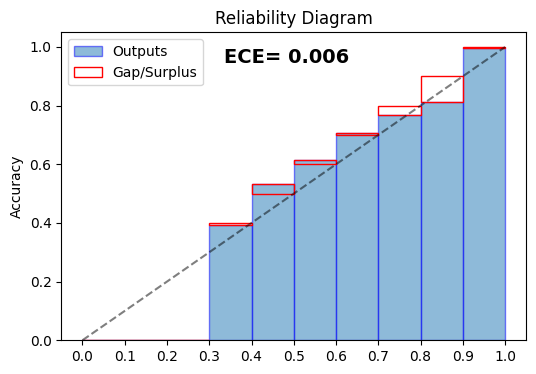

In [32]:
show_reliability_diagram(accuracy_in_bin_list, ece)

#### SCE score

In [33]:
N_BINS = 10

sce, sce_for_class_list = static_calibration_error(
                                                    calib_logits,
                                                    labels,
                                                    n_bins= N_BINS
                                                  )

print(f"Static calibration Error -> {sce}")

Static calibration Error -> 0.15361317992210388


## MODELLO 3

### Definizione del MODELLO

In [35]:
model3_name = "segformer_model1_30ep.pth"

# Load the base model
segformer_model3 = load_model_segformer(model_name=model3_name)

### Temperature Scaling

In [19]:
from torch import nn


# Define Temperature scaling Calibration
class TemperatureScaling(nn.Module):
    def __init__(self):
        super().__init__()
        self.temperature = nn.Parameter(torch.ones(1))  # Learnable temperature parameter

    def forward(self, logits):
        # print(self.temperature.item()) # -------------------------------------------DEBUG
        return logits / self.temperature.to(logits.device)  # Scale the logits

### FINE-TUNE del modello

In [22]:
calTecParams3 =  FineTune_model(segformer_model3, calibrationTecnique=TemperatureScaling() )

### SALVATAGGIO dei PESI

In [45]:
import pickle

with open(os.path.join(FOLDER_PATH_w, "temperature_scale_params_30ep.pkl"), 'wb') as f:
    pickle.dump(calTecParams3, f)

### INFERENZA

In [45]:
import pickle

with open(os.path.join(FOLDER_PATH_r, "temperature_scale_params_30ep.pkl"), 'rb') as f:
    calTecParams3 = pickle.load(f)

calTecParams3

In [20]:
def apply_temperature_scaling(logits, parameters):
    temperature = torch.Tensor(parameters[0])

    return logits/temperature

In [47]:
# Make predictions for the test dataset

calib_logits, predicted_segmentation_map, labels = make_predictions(segformer_model3, apply_temperature_scaling, calTecParams3)

  0%|          | 0/1 [00:00<?, ?it/s]

Shape of predicted_segmentation_map -> torch.Size([65, 512, 512])


### F1 score

In [48]:
print_F1_score(predicted_segmentation_map, labels)

Mean F1: 0.8085727390425704
F1 score for background (class 0): 0.9859979005351167
F1 score for crop (class 1): 0.7946391836729321
F1 score for weed (class 2): 0.6450811329196622


### ECE score

In [49]:
N_BINS = 10

ece, accuracy_in_bin_list, avg_confidence_in_bin_list = expected_calibration_error(
                                                                                    calib_logits,
                                                                                    predicted_segmentation_map,
                                                                                    labels,
                                                                                    N_BINS
                                                                                  )

In [50]:
print(f"ECE -> {ece}")
print(f"Accuracy for each bin -> {accuracy_in_bin_list}")
print(f"Confidency for each bin -> {avg_confidence_in_bin_list}")

ECE -> 0.008878249675035477
Accuracy for each bin -> [0.3535911738872528, 0.44944941997528076, 0.520420253276825, 0.5823432207107544, 0.6567946076393127, 0.7468584775924683, 0.9915856719017029]
Confidency for each bin -> [0.37810343503952026, 0.4700012803077698, 0.5502831339836121, 0.6511136293411255, 0.752371609210968, 0.8550096154212952, 0.9961340427398682]


### Reliability Diagram

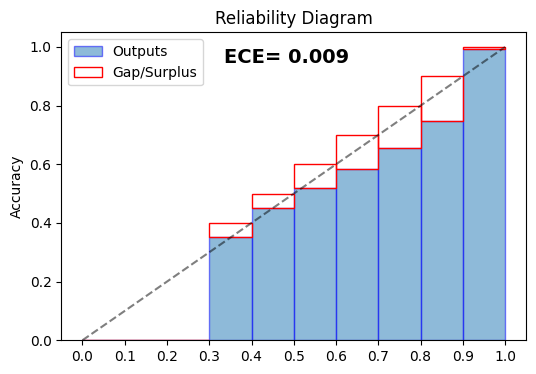

In [51]:
show_reliability_diagram(accuracy_in_bin_list, ece)

#### SCE score

In [52]:
N_BINS = 10

sce, sce_for_class_list = static_calibration_error(
                                                    calib_logits,
                                                    labels,
                                                    n_bins= N_BINS
                                                  )

print(f"Static calibration Error -> {sce}")

Static calibration Error -> 0.07578372210264206


## MODELLO 4

### Definizione del dataset e del loader

### Definizione del MODELLO

In [127]:
from transformers import SegformerForSemanticSegmentation


id2label = train_dataset.id2class # -> {0:"background", 1:"crop", 2:"weed"}
label2id = {v:k for k,v in id2label.items()} # -> {'background':0, 'crop':1, 'weed':2}

# define model
segformer_model4 = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels= len(id2label), # 3
                                                         id2label= id2label,
                                                         label2id= label2id,
)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Focal Loss

In [93]:
from torch import nn
import torch.nn.functional as F

# Define Focal Loss Calibration
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, reduction='mean'):
        """
        Unified Focal Loss class for multi-class classification tasks.
        :param gamma: Focusing parameter, controls the strength of the modulating factor (1 - p_t)^gamma
        :param reduction: Specifies the reduction method: 'none' | 'mean' | 'sum'
        """
        super(FocalLoss, self).__init__()
        self.gamma = nn.Parameter( torch.Tensor([gamma]) )
        self.reduction = reduction

    def forward(self, logits, labels):
        """
        Forward pass to compute the Focal Loss.
        :param logits: Predictions (logits) from the model.
                       Shape:
                         - multi-class: (batch_size, num_classes, height, width)
        :param labels: Ground truth labels.
                        Shape:
                         - multi-class: (batch_size, height, width)
        """
        
        ce_loss = F.cross_entropy(logits, labels, reduction="none")
        # print(f"ce_loss shape -> {ce_loss.shape}") # ------------------------------DEBUG

        # Get the class probabilities for each pixel
        pt = torch.exp(-ce_loss)
        # print(f"pt shape -> {pt.shape}") # ------------------------------DEBUG
        
        focal_loss = torch.pow((1 - pt), self.gamma.to(logits.device)) * ce_loss

        # return reducted focal_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
    
        # return whole focal_loss
        return focal_loss     


#### Esempio dimostrativo

In [17]:
import torch

input = torch.tensor([
    # batch 1
    [[
        [10, 10, 10],
        [10, 10, 10],
        [10, 10, 10]
    ], # END channel 1
    [
        [20, 20, 20],
        [20, 20, 20],
        [20, 20, 20]
    ], # END channel 2
    [
        [30, 30, 30],
        [30, 30, 30],
        [30, 30, 30]
    ]] # END channel 3
    
    ,# batch 2
    [[
        
        [20, 20, 20],
        [20, 20, 20],
        [20, 20, 20]
    ],
    [
        [30, 30, 30],
        [30, 30, 30],
        [30, 30, 30]
    ],
    [
        [10, 10, 10],
        [10, 10, 10],
        [10, 10, 10]
    ]]
], dtype=torch.float) 


targets = torch.tensor([
    # batch 1
    [
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]
    ]
    
    , # batch 2 
    [
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]
    ]
], dtype=torch.long)

print(f"Logits shape -> {input.shape}")
print(f"Labels shape -> {targets.shape}")

Logits shape -> torch.Size([2, 3, 3, 3])
Labels shape -> torch.Size([2, 3, 3])


In [2]:
focal = FocalLoss(gamma=2, reduction='sum')

loss = focal.forward(input, targets)

In [15]:
loss

### TRAINING del modello

In [110]:
import torch
import evaluate
from tqdm.notebook import tqdm
from torch import nn
import torch.nn.functional as F



def train_model_with_focal_loss(model = None):

  # Define evaluation metrics
  iou_metric = evaluate.load("mean_iou")
  f1_metric = evaluate.load("f1")

  # Define the custom loss function
  focal_loss = FocalLoss(gamma=1, reduction='sum')

  # Print parameters -----------------------------------------DEBUG
  # for name, param in focal_loss.named_parameters():
  #   print(name, param.shape, param.requires_grad)

  # Define optimizer
  optimizer = torch.optim.AdamW([ {'params': model.parameters()}, {'params': focal_loss.parameters()} ], lr=0.00006)

  # move model to GPU
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)

  # Set to training mode
  model.train()

  for epoch in range(30):  # loop over the dataset multiple times
    print("Epoch:", epoch)
    for idx, batch in enumerate(tqdm(train_dataloader)):
          # get the inputs;
          pixel_values = batch["image"].to(device)
          labels = batch["target"].to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(pixel_values=pixel_values, labels=labels)
          logits = outputs.logits

          # Scale width-height of prediction tensor to the shape of ground truth tensor
          upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)

          # --------------------------------DEBUG
          # print(upsampled_logits.shape)
          # print(labels.shape)
        
          # Compute custom loss
          loss = focal_loss(upsampled_logits, labels)

          loss.backward()
          optimizer.step()

          # evaluation for training
          with torch.no_grad():
            
            softmaxes = F.softmax(upsampled_logits, dim=1)
              
            # Choose the most probable class for each pixel
            predicted = softmaxes.argmax(dim=1)

            # note that the metric expects predictions + labels as numpy arrays
            iou_metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())


          # let's print loss and metrics every 100 batches (we have only 18 batch for epoch, so... print them only one)
          if idx % 100 == 0:

            # IoU metric
            iou_metrics = iou_metric._compute(
                    predictions=predicted.cpu(),
                    references=labels.cpu(),
                    num_labels=len(id2label),
                    ignore_index=255,
                    reduce_labels=False, # we've already reduced the labels ourselves
                )

            # F1 metric
            f1_metrics = f1_metric._compute(
                    predictions=predicted.cpu().flatten(),  # Flatten tensors for classification metrics
                    references=labels.cpu().flatten(),
                    average="macro"
                )

            print("Loss:", loss.item())
            print("Mean_iou:", iou_metrics["mean_iou"])
            print("Mean accuracy:", iou_metrics["mean_accuracy"])
            print("Mean f1:", f1_metrics["f1"])

  return [p for p in focal_loss.parameters()]

In [128]:
trained_gamma = train_model_with_focal_loss(segformer_model4)

print(f"trained gamma hyperparameter -> {trained_gamma}")

### SALVATAGGIO dei PESI del modello & IPERPARAMETRI della Focal loss

In [113]:
import pickle

model_name = "segformer_model_with_focal_1g_30ep.pth"
gamma_focalLoss_name = "focal_gamma_params_1g_30ep.pth"

# Save the model
save_model_weights(model=segformer_model4, model_name=model_name)

# Save the gamma parameter
with open(os.path.join(FOLDER_PATH_w, gamma_focalLoss_name), 'wb') as f:
    pickle.dump(trained_gamma, f)

✅ Model weights saved to /kaggle/working/segformer_model_with_focal_1g_30ep.pth


### CARICAMENTO dei PESI del modello

In [130]:
import pickle

model_name = "segformer_model_with_focal_1g_30ep.pth"
gamma_focalLoss_name = "focal_gamma_params_1g_30ep.pth"


# Load model architecture from local folder
segformer_model4 = load_model_segformer(model_name=model_name)

# Load hyperparameter gamma
with open(os.path.join(FOLDER_PATH_r, gamma_focalLoss_name), 'rb') as f:
    trained_gamma = pickle.load(f)

In [131]:
trained_gamma

[Parameter containing:
 tensor([1.0157], requires_grad=True)]

### FINE-TUNE del modello

In [132]:
calTecParams4 =  FineTune_model(
                                    segformer_model4, 
                                    # calibrationTecnique= MatrixScaling(n_batches=16, n_channels=3, height=512, width=512)
                                    calibrationTecnique= TemperatureScaling()
                                )

In [115]:
import pickle

with open(os.path.join(FOLDER_PATH_w, "focal_temperature_scale_params_1g_30ep.pkl"), 'wb') as f:
    pickle.dump(calTecParams4, f)

### INFERENZA

In [133]:
import pickle

with open(os.path.join(FOLDER_PATH_r, "focal_temperature_scale_params_1g_30ep.pkl"), 'rb') as f:
    calTecParams4 = pickle.load(f)

calTecParams4

[Parameter containing:
 tensor([0.6408], requires_grad=True)]

In [116]:
calTecParams4

[Parameter containing:
 tensor([0.6408], requires_grad=True)]

In [134]:
# Make predictions for the test dataset

calib_logits, predicted_segmentation_map, labels = make_predictions(
                                                                    segformer_model4, 
                                                                    # apply_matrix_scaling,
                                                                    apply_temperature_scaling, 
                                                                    calTecParams4
                                                                   )

  0%|          | 0/1 [00:00<?, ?it/s]

Shape of predicted_segmentation_map -> torch.Size([65, 512, 512])


### F1 score

In [135]:
print_F1_score(predicted_segmentation_map, labels)

Mean F1: 0.821553112598436
F1 score for background (class 0): 0.9849313228713036
F1 score for crop (class 1): 0.7910636525816286
F1 score for weed (class 2): 0.6886643623423759


### ECE score

In [136]:
N_BINS = 10

ece, accuracy_in_bin_list, avg_confidence_in_bin_list = expected_calibration_error(
                                                                                    calib_logits,
                                                                                    predicted_segmentation_map,
                                                                                    labels,
                                                                                    N_BINS
                                                                                  )

In [137]:
print(f"ECE -> {ece}")
print(f"Accuracy for each bin -> {accuracy_in_bin_list}")
print(f"Confidency for each bin -> {avg_confidence_in_bin_list}")

ECE -> 0.02810245379805565
Accuracy for each bin -> [0.39658230543136597, 0.500104546546936, 0.5754408836364746, 0.6854345798492432, 0.80311518907547, 0.9237935543060303, 0.9982997179031372]
Confidency for each bin -> [0.37821266055107117, 0.47276929020881653, 0.5503671765327454, 0.651328980922699, 0.7531920671463013, 0.8574534058570862, 0.9733707308769226]


### Reliability Diagram

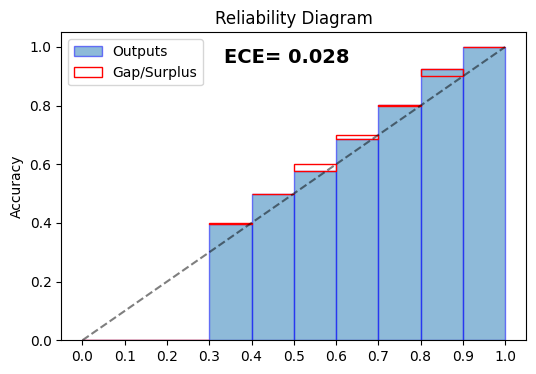

In [138]:
show_reliability_diagram(accuracy_in_bin_list, ece)

### SCE score

In [139]:
N_BINS = 10

sce, sce_for_class_list = static_calibration_error(
                                                    calib_logits,
                                                    labels,
                                                    n_bins= N_BINS
                                                  )

print(f"Static calibration Error -> {sce}")

Static calibration Error -> 0.129982590675354


# CONFRONTO F1

### MODELLO 1 - BASE
```
Mean F1: 0.8085727390425704
F1 score for background (class 0): 0.9859979005351167
F1 score for crop (class 1): 0.7946391836729321
F1 score for weed (class 2): 0.6450811329196622
```

### MODELLO 2
```
15ep

Mean F1: 0.46377039283415716
F1 score for background (class 0): 0.9734095479821827
F1 score for crop (class 1): 0.18111994645717316
F1 score for weed (class 2): 0.23678168406311573


50ep

Mean F1: 0.7335286637518083
F1 score for background (class 0): 0.9839361661816733
F1 score for crop (class 1): 0.6917533317890654
F1 score for weed (class 2): 0.5248964932846862


100ep

Mean F1: 0.7583323928812374
F1 score for background (class 0): 0.9851042811204375
F1 score for crop (class 1): 0.7321035268856062
F1 score for weed (class 2): 0.5577893706376685
```

### MODELLO 3
```
15ep

Mean F1: 0.8085727390425704
F1 score for background (class 0): 0.9859979005351167
F1 score for crop (class 1): 0.7946391836729321
F1 score for weed (class 2): 0.6450811329196622


30 ep

Mean F1: 0.8085727390425704
F1 score for background (class 0): 0.9859979005351167
F1 score for crop (class 1): 0.7946391836729321
F1 score for weed (class 2): 0.6450811329196622
```

### MODELLO 4
```
30 ep | gamma -> 2.0126 (input 2)

Temprerature scaling

Mean F1: 0.8305977333645296
F1 score for background (class 0): 0.986392622337877
F1 score for crop (class 1): 0.8080084087622517
F1 score for weed (class 2): 0.6973921689934601


Matrix scaling

Mean F1: 0.6653326522464588
F1 score for background (class 0): 0.9805069669216279
F1 score for crop (class 1): 0.546556356574712
F1 score for weed (class 2): 0.4689346332430364



30 ep | gamma -> 1.0157 (input 1)

Temprerature scaling

Mean F1: 0.821553112598436
F1 score for background (class 0): 0.9849313228713036
F1 score for crop (class 1): 0.7910636525816286
F1 score for weed (class 2): 0.6886643623423759

```